In [1]:
import os
import sys
import numpy as np
import pandas as pd
from FTS import fts_util
from PyEMD import EMD
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
cores = sns.color_palette(n_colors=21)
warnings.filterwarnings('ignore')

## Grid Search in Alabama Time Series

In [2]:
if not os.path.isdir('out'):
    try:
        os.mkdir('out')
        print('created')
    except:
        print("don't create path out")

In [3]:
# read tsfcm_labels
ala = pd.read_csv('data/Enrollments.csv', sep=';', index_col=[0], parse_dates=[0])
col = ala.keys().to_list()[0]

file_results = 'out/QE_GS_Alabama.csv'

# apply EMD to get IMFs
emd = EMD()
imfs = emd.emd(ala[col].values)

''' Select MFIs without trending and noise behavior '''

df_fts = pd.DataFrame(ala[col].copy())
df_fts[col] = ala

col_imf = 'residue'
df_fts[col_imf] = imfs[1]+imfs[2]

In [4]:
from FTS.Models.MV_Lee import STFMV_Convencional_Lee
model = STFMV_Convencional_Lee()

In [5]:
for k in range(2, 22):
    # run model
    model.fit(X=df_fts[[col, col_imf]].values, k=k)
    mape, mae, mse, rmse, dtw = model.predict(plot=False, SM=False)
    
    # verify and save 
    experimento = {'IMF':col_imf, 'amount':k, 'MAPE':mape, 'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'DTW':dtw}
    
    fts_util.update_values_exp(experimento, key_words=['IMF','amount', 'MSE'], fp=file_results, log=False)

In [6]:
df_view = pd.read_csv(file_results, index_col=['amount'])
df_view

IMF  MAPE     MAE        MSE    RMSE           DTW
amount                                                        
2       residue  4.24  672.00  747969.06  864.85  14112.067973
3       residue  4.04  643.31  595371.19  771.60  12378.890972
4       residue  2.77  437.07  330200.77  574.63   7985.443184
5       residue  2.65  423.07  269893.52  519.51   7486.928991
6       residue  2.50  399.04  233303.83  483.02   6721.110710
7       residue  2.29  373.40  204347.41  452.05   5997.311397
8       residue  2.29  368.38  193983.49  440.44   6667.294328
9       residue  1.64  260.51  110213.55  331.98   4803.935771
10      residue  1.65  266.11  124308.71  352.57   4877.296135
11      residue  1.39  218.16   96395.02  310.48   3899.750490
12      residue  1.48  238.82  124509.09  352.86   4832.651035
13      residue  1.08  168.77   61646.74  248.29   3382.791007
14      residue  1.03  160.17   49445.35  222.36   3019.171039
15      residue  0.88  135.21   48654.32  220.58   2575.354025
16      residue  1.22  196.94  115227.53  339.45   3948.690251
17      residue  0.40   68.79   19125.40  138.29   1285.904043
18      residue  0.40   68.60   19314.32  138.98   1281.939816
19      residue  0.30   52.43   17976.08  134.07    942.292869
20      residue  0.35   61.01   18738.29  136.89   1122.471907
21      residue  0.12   22.17    9925.43   99.63    465.502933

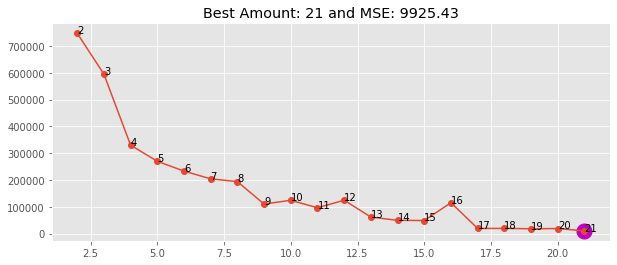

In [7]:
best = fts_util.best_GS(df_view, 'MSE')

plt.figure(figsize=(10,4))
plt.plot(best.index.values[0], best['MSE'].values[0], '-mo', markersize=15)
plt.title('Best Amount: {} and MSE: {}'.format(best.index.values[0], best['MSE'].values[0]))
plt.plot(df_view['MSE'], '-o')
for i in range(df_view.shape[0]):
    plt.annotate(df_view.index[i], (df_view.index[i], df_view['MSE'].iloc[i]))
plt.show()